In [105]:
suppressPackageStartupMessages({
    library(edgeR)
    library(dplyr)
    library(ggplot2)
    library(reshape2)
    library(biomaRt)
    library(dplyr)
    library(stringr)
})

In [39]:
# URL of the compressed file
url <- "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE223nnn/GSE223100/suppl/GSE223100%5Fcounts.txt.gz"

# Download the compressed file to a temporary location
temp_compressed <- tempfile(fileext = ".gz")
download.file(url, temp_compressed)

# Decompress the file
temp_decompressed <- tempfile()
gzfile <- gzfile(temp_compressed, "rb")
writeLines(readLines(gzfile), temp_decompressed)
close(gzfile)

In [76]:
metadata <- read.csv2("metadata.csv", sep = ",")
head(metadata)

,Sample,Tissue,CellType
,<chr>,<chr>,<chr>
1,BM_pDCs_R1,Bone Marrow,pDCs
2,BM_pDC_like_R1,Bone Marrow,pDC-like
3,Spl_pDCs_R1,Spleen,pDCs
4,Spl_pDC_like_R1,Spleen,pDC-like
5,Spl_cDC1_R1,Spleen,cDC1
6,Spl_cDC2_R1,Spleen,cDC2


In [131]:
counts <- read.table(temp_compressed, header = TRUE, sep = '\t', na.strings = '', row.names = 1)[-1]
names(counts) <- metadata$Sample
counts <- as.matrix(counts)
head(counts)

,BM_pDCs_R1,BM_pDC_like_R1,Spl_pDCs_R1,Spl_pDC_like_R1,Spl_cDC1_R1,Spl_cDC2_R1,Thy_pDCs_R1,Thy_pDC_like_R1,Thy_cDC1_R1,Thy_cDC2_R1,⋯,Spl_cDC1_R3,Spl_cDC2_R3,Thy_pDCs_R3,Thy_pDC_like_R3,Thy_cDC1_R3,Thy_cDC2_R3,mLN_pDCs_R3,mLN_pDC_like_R3,mLN_cDC1_R3,mLN_cDC2_R3
ENSMUSG00000103416,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000017688,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000102283,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000077829,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000069125,12,27,31,18,50,53,12,40,32,19,⋯,45,84,34,36,50,41,27,18,24,31
ENSMUSG00000103245,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Annotate

In [113]:
ensembl <- useMart("ensembl")
datasets <- listDatasets(ensembl)
datasets %>%
  filter(str_detect(dataset, "musculus"))

dataset,description,version
<I<chr>>,<I<chr>>,<I<chr>>
bmusculus_gene_ensembl,Blue whale genes (mBalMus1.v2),mBalMus1.v2
mmusculus_gene_ensembl,Mouse genes (GRCm39),GRCm39


In [114]:
mart <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
ensembl_annot <- getBM(attributes=c("ensembl_gene_id","external_gene_name"),
                       filters = "ensembl_gene_id",
                       values = rownames(counts), 
                       mart = mart)


Batch submitting query [==>----------------------------]   8% eta:  5m

Batch submitting query [====>--------------------------]  17% eta:  4m

Batch submitting query [=======>-----------------------]  25% eta:  3m

Batch submitting query [=========>---------------------]  33% eta:  2m

Batch submitting query [============>------------------]  42% eta:  2m

Batch submitting query [===============>---------------]  50% eta:  2m

Batch submitting query [=================>-------------]  58% eta:  1m

Batch submitting query [====================>----------]  67% eta:  1m

Batch submitting query [======================>--------]  75% eta:  1m

Batch submitting query [=========================>-----]  83% eta: 43s

Batch submitting query [===========================>---]  92% eta: 20s
                                                                      



In [132]:
cols <- as.data.frame(rownames(counts))
new_names <- left_join(cols, ensembl_annot, by = c("rownames(counts)" = "ensembl_gene_id"))
rownames(counts) <- new_names$external_gene_name
counts <- counts[!is.na(rownames(counts)), ]
head(counts)

,BM_pDCs_R1,BM_pDC_like_R1,Spl_pDCs_R1,Spl_pDC_like_R1,Spl_cDC1_R1,Spl_cDC2_R1,Thy_pDCs_R1,Thy_pDC_like_R1,Thy_cDC1_R1,Thy_cDC2_R1,⋯,Spl_cDC1_R3,Spl_cDC2_R3,Thy_pDCs_R3,Thy_pDC_like_R3,Thy_cDC1_R3,Thy_cDC2_R3,mLN_pDCs_R3,mLN_pDC_like_R3,mLN_cDC1_R3,mLN_cDC2_R3
Gm37338,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Hnf4g,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Gm37000,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Rps24-ps2,12,27,31,18,50,53,12,40,32,19,⋯,45,84,34,36,50,41,27,18,24,31
Pou5f1-rs3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Gm2077,80,91,114,97,160,186,51,157,103,63,⋯,75,189,91,88,86,96,63,76,69,70


In [133]:
# Create a box plot
counts_mat <- as.matrix(counts)
box_plot <- ggplot(data = melt(counts_mat), aes(x = Var2, y = value)) +
  geom_boxplot() +
  labs(x = "Samples", y = "Counts") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + # Rotate x-axis labels for better readability
  ggtitle("Box Plot of Counts Matrix")

# Compute summary statistics
summary_stats <- apply(counts_mat, 2, summary)
formatted_summary <- t(round(summary_stats, 2)) 

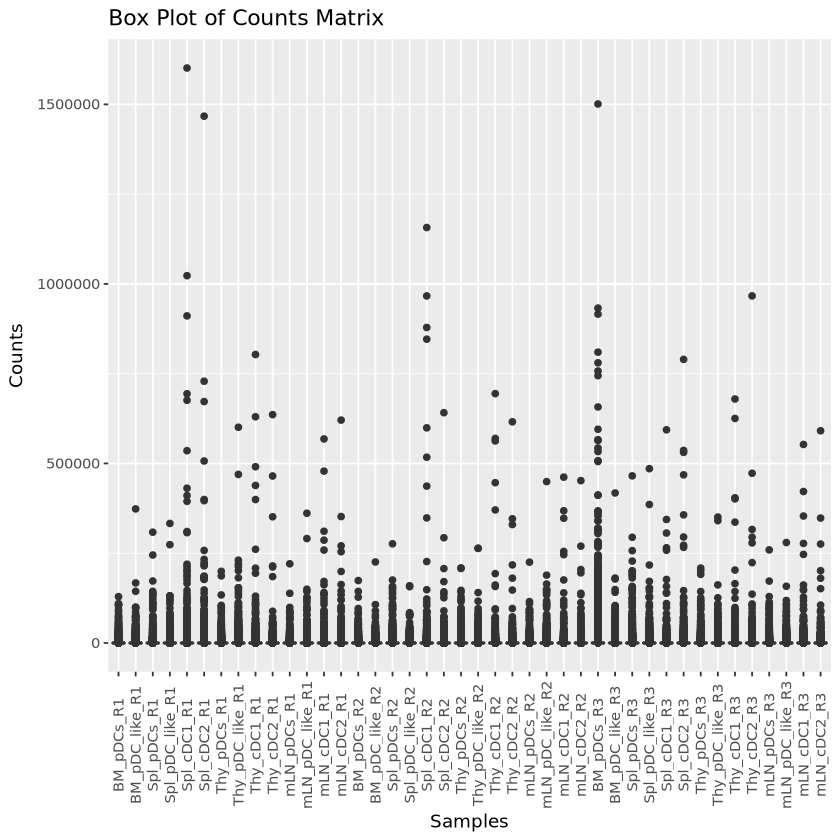

In [134]:
box_plot

In [135]:
print(knitr::kable(formatted_summary, caption = "Summary Statistics", align = "c"))



Table: Summary Statistics

|                | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. |  Max.   |
|:---------------|:----:|:-------:|:------:|:-------:|:-------:|:-------:|
|BM_pDCs_R1      |  0   |    0    |   0    | 327.18  |   41    | 129115  |
|BM_pDC_like_R1  |  0   |    0    |   0    | 534.60  |   68    | 373365  |
|Spl_pDCs_R1     |  0   |    0    |   0    | 522.12  |   60    | 308531  |
|Spl_pDC_like_R1 |  0   |    0    |   0    | 534.48  |   69    | 332906  |
|Spl_cDC1_R1     |  0   |    0    |   0    | 1009.40 |   106   | 1601199 |
|Spl_cDC2_R1     |  0   |    0    |   0    | 961.10  |   117   | 1467053 |
|Thy_pDCs_R1     |  0   |    0    |   0    | 324.16  |   36    | 199626  |
|Thy_pDC_like_R1 |  0   |    0    |   0    | 737.41  |   94    | 600788  |
|Thy_cDC1_R1     |  0   |    0    |   0    | 562.39  |   60    | 803291  |
|Thy_cDC2_R1     |  0   |    0    |   0    | 396.82  |   57    | 635900  |
|mLN_pDCs_R1     |  0   |    0    |   0    | 353.09  |   42    | 220555

## Normalize data


In [136]:
dgeFull1 = DGEList(counts = counts, group = metadata$condition)
dim(dgeFull1)

[1] 52184    42

In [137]:
dgeFull1 <- calcNormFactors(dgeFull1, method="TMM")
head(dgeFull1$samples)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
BM_pDCs_R1,1,17073555,1.1450753
BM_pDC_like_R1,1,27897753,1.1024703
Spl_pDCs_R1,1,27246311,1.0108743
Spl_pDC_like_R1,1,27891275,1.0341418
Spl_cDC1_R1,1,52674758,0.8757537
Spl_cDC2_R1,1,50154048,0.8968853


In [139]:
eff.lib.size0 <-  dgeFull1$samples$lib.size*dgeFull1$samples$norm.factors
analysis <- data.frame(cpm(dgeFull1))
colnames(analysis) <- sub(pattern = "^X", replacement = "", colnames(analysis))
analysis <-as.matrix(analysis)
head(analysis)

,BM_pDCs_R1,BM_pDC_like_R1,Spl_pDCs_R1,Spl_pDC_like_R1,Spl_cDC1_R1,Spl_cDC2_R1,Thy_pDCs_R1,Thy_pDC_like_R1,Thy_cDC1_R1,Thy_cDC2_R1,⋯,Spl_cDC1_R3,Spl_cDC2_R3,Thy_pDCs_R3,Thy_pDC_like_R3,Thy_cDC1_R3,Thy_cDC2_R3,mLN_pDCs_R3,mLN_pDC_like_R3,mLN_cDC1_R3,mLN_cDC2_R3
Gm37338,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Hnf4g,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Gm37000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Rps24.ps2,0.6137948,0.8778648,1.125529,0.6240567,1.083891,1.178238,0.7130474,1.037856,1.122312,0.9444426,⋯,2.458409,3.363980,1.497725,1.333266,2.095012,1.556962,1.217383,0.8834952,1.083223,1.618972
Pou5f1.rs3,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Gm2077,4.0919657,2.9587296,4.139043,3.3629720,3.468450,4.134948,3.0304515,4.073584,3.612441,3.1315728,⋯,4.097348,7.568954,4.008617,3.259094,3.603421,3.645570,2.840559,3.7303132,3.114267,3.655743


## View normalized data


In [140]:
# Create a box plot
counts_mat <- analysis
box_plot <- ggplot(data = melt(counts_mat), aes(x = Var2, y = value)) +
  geom_boxplot() +
  labs(x = "Samples", y = "Counts") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + # Rotate x-axis labels for better readability
  ggtitle("Box Plot of Counts Matrix")

# Compute summary statistics
summary_stats <- apply(counts_mat, 2, summary)
formatted_summary <- t(round(summary_stats, 2)) 

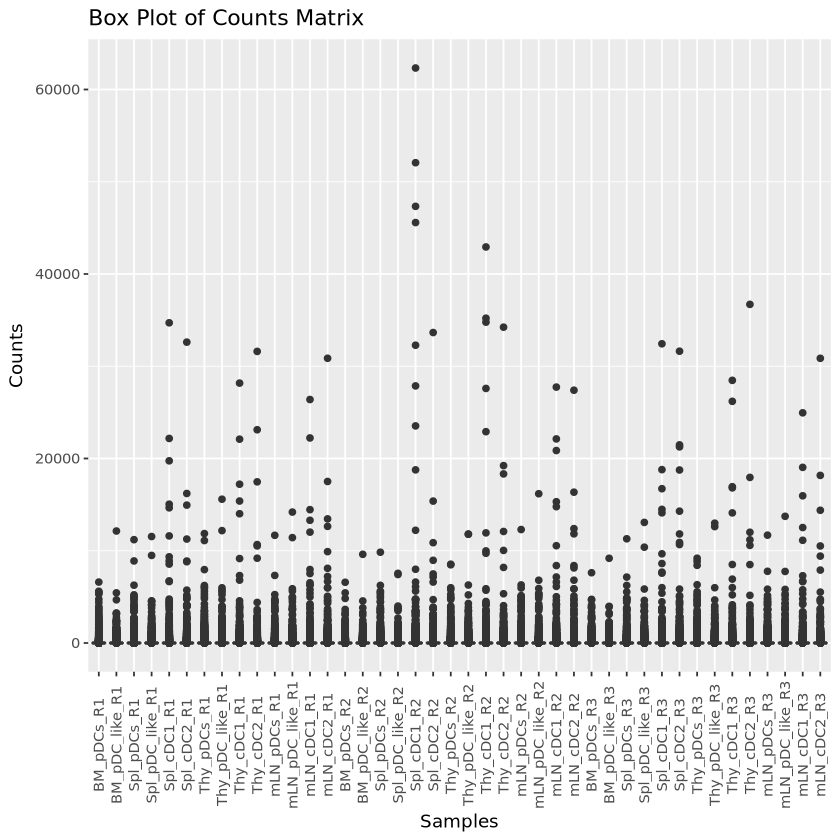

In [142]:
box_plot

In [143]:
print("Summary Statistics:")
print(knitr::kable(formatted_summary, caption = "Summary Statistics", align = "c"))

[1] "Summary Statistics:"


Table: Summary Statistics

|                | Min. | 1st Qu. | Median | Mean  | 3rd Qu. |   Max.   |
|:---------------|:----:|:-------:|:------:|:-----:|:-------:|:--------:|
|BM_pDCs_R1      |  0   |    0    |  0.00  | 16.74 |  2.10   | 6604.18  |
|BM_pDC_like_R1  |  0   |    0    |  0.00  | 17.38 |  2.21   | 12139.41 |
|Spl_pDCs_R1     |  0   |    0    |  0.00  | 18.96 |  2.18   | 11201.96 |
|Spl_pDC_like_R1 |  0   |    0    |  0.00  | 18.53 |  2.39   | 11541.79 |
|Spl_cDC1_R1     |  0   |    0    |  0.00  | 21.88 |  2.30   | 34710.49 |
|Spl_cDC2_R1     |  0   |    0    |  0.00  | 21.37 |  2.60   | 32613.91 |
|Thy_pDCs_R1     |  0   |    0    |  0.00  | 19.26 |  2.14   | 11861.90 |
|Thy_pDC_like_R1 |  0   |    0    |  0.00  | 19.13 |  2.44   | 15588.28 |
|Thy_cDC1_R1     |  0   |    0    |  0.00  | 19.72 |  2.10   | 28173.21 |
|Thy_cDC2_R1     |  0   |    0    |  0.00  | 19.72 |  2.83   | 31609.00 |
|mLN_pDCs_R1     |  0   |    0    |  0.00  | 18.69 |  2.2

## Make server files


In [144]:
head(analysis)

,BM_pDCs_R1,BM_pDC_like_R1,Spl_pDCs_R1,Spl_pDC_like_R1,Spl_cDC1_R1,Spl_cDC2_R1,Thy_pDCs_R1,Thy_pDC_like_R1,Thy_cDC1_R1,Thy_cDC2_R1,⋯,Spl_cDC1_R3,Spl_cDC2_R3,Thy_pDCs_R3,Thy_pDC_like_R3,Thy_cDC1_R3,Thy_cDC2_R3,mLN_pDCs_R3,mLN_pDC_like_R3,mLN_cDC1_R3,mLN_cDC2_R3
Gm37338,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Hnf4g,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Gm37000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Rps24.ps2,0.6137948,0.8778648,1.125529,0.6240567,1.083891,1.178238,0.7130474,1.037856,1.122312,0.9444426,⋯,2.458409,3.363980,1.497725,1.333266,2.095012,1.556962,1.217383,0.8834952,1.083223,1.618972
Pou5f1.rs3,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,⋯,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000
Gm2077,4.0919657,2.9587296,4.139043,3.3629720,3.468450,4.134948,3.0304515,4.073584,3.612441,3.1315728,⋯,4.097348,7.568954,4.008617,3.259094,3.603421,3.645570,2.840559,3.7303132,3.114267,3.655743


In [146]:
head(metadata)

,Sample,Tissue,CellType
,<chr>,<chr>,<chr>
1,BM_pDCs_R1,Bone Marrow,pDCs
2,BM_pDC_like_R1,Bone Marrow,pDC-like
3,Spl_pDCs_R1,Spleen,pDCs
4,Spl_pDC_like_R1,Spleen,pDC-like
5,Spl_cDC1_R1,Spleen,cDC1
6,Spl_cDC2_R1,Spleen,cDC2


In [148]:
phen <- metadata %>%
    rename(
        Condition = Tissue
        )
head(phen)

,Sample,Condition,CellType
,<chr>,<chr>,<chr>
1,BM_pDCs_R1,Bone Marrow,pDCs
2,BM_pDC_like_R1,Bone Marrow,pDC-like
3,Spl_pDCs_R1,Spleen,pDCs
4,Spl_pDC_like_R1,Spleen,pDC-like
5,Spl_cDC1_R1,Spleen,cDC1
6,Spl_cDC2_R1,Spleen,cDC2


In [149]:
unique(phen$Condition)

[1] "Bone Marrow"            "Spleen"                 "Thymus"                
[4] "mesenteric Lymph Nodes"

In [151]:
saveRDS(analysis, file = file.path("BM_SP_TH_LN_RNAseq_GSE223100", "expression.rds"))
saveRDS(phen, file = file.path("BM_SP_TH_LN_RNAseq_GSE223100", "metadata.rds"))